# Support Vector Regressor Modeling

# Importing Necessary Libraries

In [1]:
# Install gitpath below if not already available on your environment.
#! pip install git+https://github.com/maxnoe/python-gitpath
import gitpath

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Importing the Data

In [2]:
#Getting the file path for the data file.
file_path = str(gitpath.root()) + '/data/no_nans_data.xlsx'

In [3]:
df = pd.read_excel(file_path)
df['Contract Years Left'] = df['Contract Years Left'].apply(lambda x:int(x))

# Separating Data by Position

In [4]:
attack = df[df['Position']=='attack']
midfield = df[df['Position']=='midfield']
defence = df[df['Position']=='Defender']

# Support Vector Regressor with all Features and Default Hyperparameters

In [5]:
#Splitting the data

X = attack.drop(['Player','Value','Club','Position','Nation','League'],axis=1)
y = attack['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [6]:
#Pre-processing data

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)


#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

In [7]:
#Initiating Support Vector Regressor to calculate feature importance
svr = SVR(kernel='linear')
svr.fit(X_train_scaled,y_train);

In [8]:
cross_val_train = cross_val_score(svr, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(svr, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

In [9]:
#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

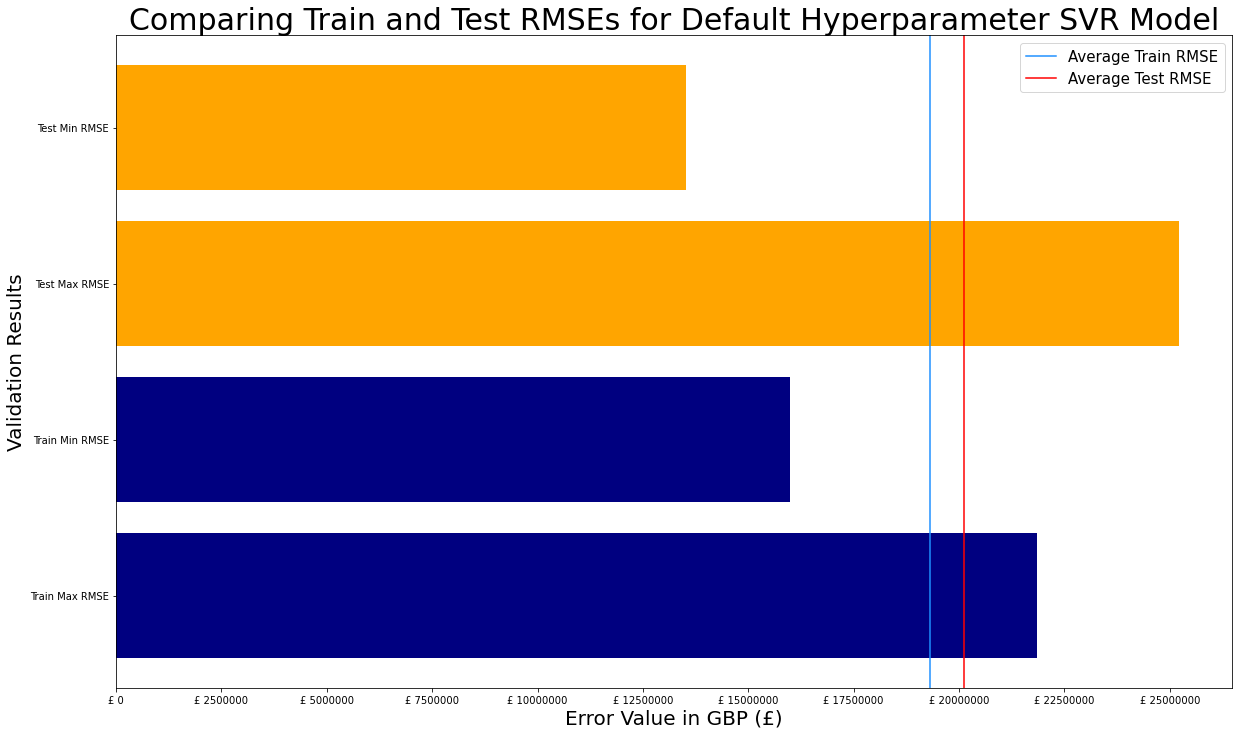

In [10]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,max([results.iloc[0][2],(round(results.iloc[1][2])+1000000)]),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Comparing Train and Test RMSEs for Default Hyperparameter SVR Model',fontsize=30)
ax.legend(fontsize=15);

# Hyperparameter Tuning. (Finding  Hyperparameters that may improve our model performance)

Since a GridSearch would take a long time to run with all our features, we will perform a GridSearch for a model that would only take the top 10 most important features.

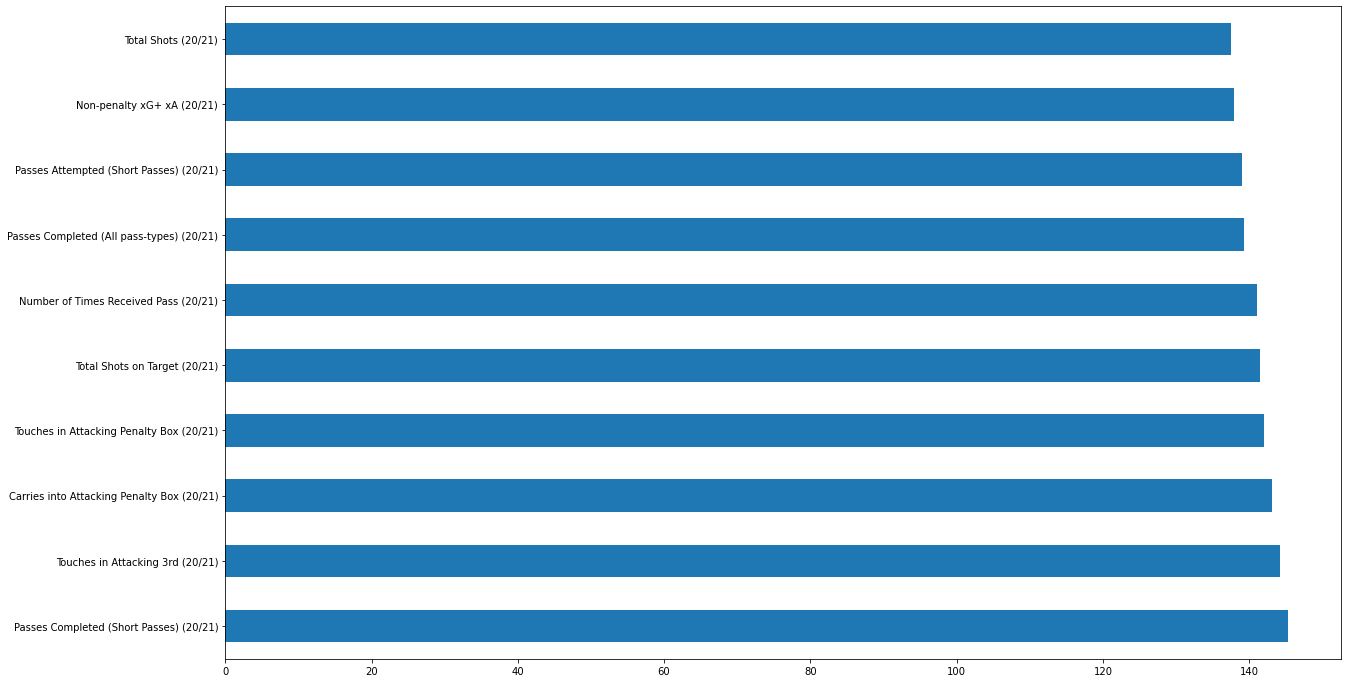

In [11]:
fig,ax = plt.subplots(figsize=(20,12))

pd.Series(abs(svr.coef_[0]), index=X.columns).nlargest(10).plot(kind='barh');

In [12]:
#Creating a list of top features
top_features = list(pd.Series(abs(svr.coef_[0]), index=X.columns).nlargest(10).keys())

## Building a newer model. This time only with important features

In [13]:
X = attack.drop(['Player','Value','Club','Position','Nation','League'],axis=1)[top_features]
y = attack['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [14]:
#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

In [15]:
# Create the parameter grid based on the results of random search 
parameters = { 'C':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear'],
              'degree':[1,2,3,4,5,6],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

In [16]:
# Instantiate the grid search
grid_search = GridSearchCV(estimator = svr, param_grid = parameters, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [17]:
%%capture
grid_search.fit(X_train_scaled,y_train)

In [18]:
grid_search.best_params_

{'C': 1000, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}

# Using a Support Vector Regressor with important features and better Parameters

In [19]:
param_values = list((grid_search.best_params_).values())

In [20]:
param_values

[1000, 5, 1, 'poly']

In [21]:
# Traning model with all features using best SVR Hyperparameters
svr_Grid = SVR(C = param_values[0],
              degree = param_values[1],
              gamma = param_values[2],
              kernel=param_values[3])

svr_Grid.fit(X_train_scaled,y_train);

In [22]:
cross_val_train = cross_val_score(svr_Grid, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(svr_Grid, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

In [23]:
#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results_att = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results_att.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results_att.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

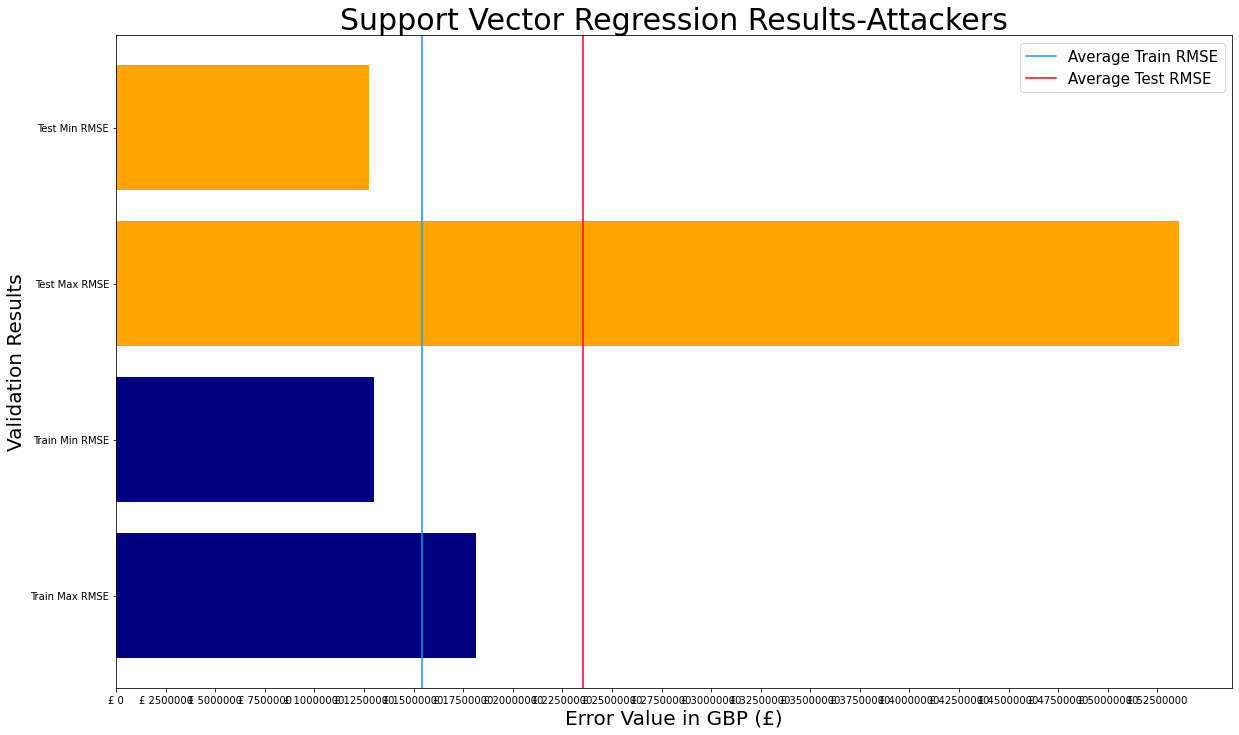

In [24]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,int(max(results_att['Max RMSE'])+1000000),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results_att.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results_att.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results_att.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results_att.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results_att.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results_att.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Support Vector Regression Results-Attackers',fontsize=30)
ax.legend(fontsize=15);

# Applying the above workflow for Midfielders

In [25]:
#Splitting the data

X = midfield.drop(['Player','Value','Club','Position','Nation','League'],axis=1)
y = midfield['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

############################################################################

#Fitting data into first SVR Model to get important features

#Initiating Support Vector Regressor
svr = SVR(kernel='linear')

svr.fit(X_train_scaled,y_train);

############################################################################

#Creating a list of top features
top_features = list(pd.Series(abs(svr.coef_[0]), index=X.columns).nlargest(10).keys())

############################################################################

#Repeating Workflow. This time only with most important features.

#This is because of computational constraints from GridSearching over 500 features.

X = midfield.drop(['Player','Value','Club','Position','Nation','League'],axis=1)[top_features]
y = midfield['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)


############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

In [26]:
%%capture
#GridSearching improved hyperparameters

# Hyper parameters range intialization for tuning 

# Create the parameter grid based on the results of random search 
parameters = { 'C':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear'],
              'degree':[1,2,3,4,5,6],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_search=GridSearchCV(svr,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=5,verbose=5)

grid_search.fit(X_train_scaled,y_train)


#Extracting the best Parameters
param_values = list((grid_search.best_params_).values())

In [27]:
#Initiating a new Support Vector Regressor

# Traning model with all features using best SVR Hyperparameters
svr_Grid = SVR(C = param_values[0],
              degree = param_values[1],
              gamma = param_values[2],
              kernel=param_values[3])

svr_Grid.fit(X_train_scaled,y_train);


cross_val_train = cross_val_score(svr_Grid, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(svr_Grid, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results_mid = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results_mid.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results_mid.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

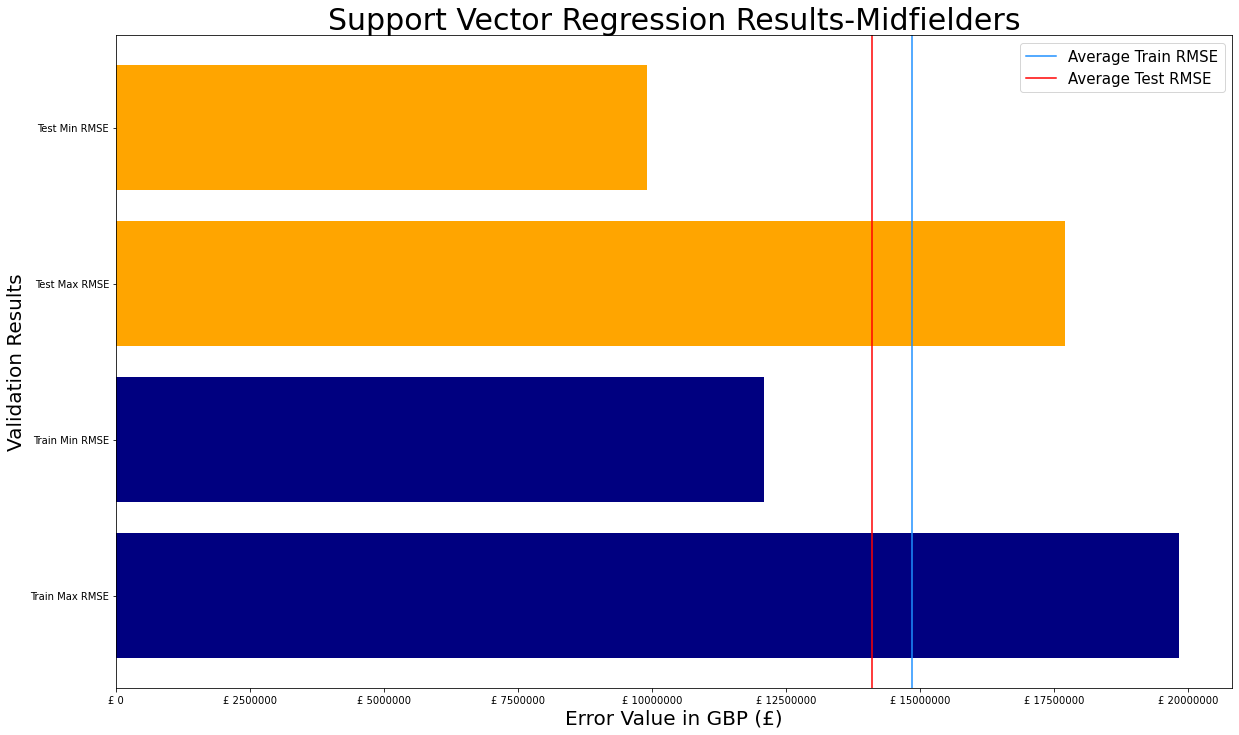

In [28]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,int(max(results_mid['Max RMSE'])+1000000),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results_mid.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results_mid.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results_mid.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results_mid.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results_mid.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results_mid.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Support Vector Regression Results-Midfielders',fontsize=30)
ax.legend(fontsize=15);

# Applying the above workflow for Defenders

In [29]:
#Splitting the data

X = defence.drop(['Player','Value','Club','Position','Nation','League'],axis=1)
y = defence['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

############################################################################

#Fitting data into first SVR Model to get important features

#Initiating Support Vector Regressor
svr = SVR(kernel='linear')

svr.fit(X_train_scaled,y_train);

############################################################################

#Creating a list of top features
top_features = list(pd.Series(abs(svr.coef_[0]), index=X.columns).nlargest(10).keys())

############################################################################

#Repeating Workflow. This time only with most important features.

#This is because of computational constraints from GridSearching over 500 features.

X = defence.drop(['Player','Value','Club','Position','Nation','League'],axis=1)[top_features]
y = defence['Value']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)


############################################################################

#Pre-processing

#Making the distribution of the features more Gaussian
pt = PowerTransformer()

X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

#Scaling the data

#Initiating Robust Scaler
rs= RobustScaler()

#Standardizing numerical columns
X_train_scaled = rs.fit_transform(X_train_transformed)
X_test_scaled = rs.transform(X_test_transformed)

In [30]:
%%capture
#GridSearching improved hyperparameters

# Hyper parameters range intialization for tuning 

# Create the parameter grid based on the results of random search 
parameters = { 'C':[0.1,1,100,1000],
              'kernel':['rbf','poly','sigmoid','linear'],
              'degree':[1,2,3,4,5,6],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_search=GridSearchCV(svr,param_grid=parameters,scoring='neg_root_mean_squared_error',cv=5,verbose=5)

grid_search.fit(X_train_scaled,y_train)


#Extracting the best Parameters
param_values = list((grid_search.best_params_).values())

In [31]:
#Initiating a new Support Vector Regressor

# Traning model with all features using best SVR Hyperparameters
svr_Grid = SVR(C = param_values[0],
              degree = param_values[1],
              gamma = param_values[2],
              kernel=param_values[3])

svr_Grid.fit(X_train_scaled,y_train);


cross_val_train = cross_val_score(svr_Grid, X_train_scaled, y_train, scoring="neg_root_mean_squared_error",cv=5)
cross_val_test = cross_val_score(svr_Grid, X_test_scaled, y_test, scoring="neg_root_mean_squared_error",cv=5)

#Train Results
cross_val_train_mean = round(-(cross_val_train.mean()),2)
cross_val_train_max = round(-(cross_val_train.min()),2)
cross_val_train_min = round(-(cross_val_train.max()),2)

#Test Results
cross_val_test_mean = round(-(cross_val_test.mean()),2)
cross_val_test_max = round(-(cross_val_test.min()),2)
cross_val_test_min = round(-(cross_val_test.max()),2)

#Creating a Dataframe to display Validation Results
results_def = pd.DataFrame(columns=['Train/Test','Avg RMSE','Max RMSE','Min RMSE'])
results_def.loc[0] = ['Train',cross_val_train_mean,cross_val_train_max,cross_val_train_min]
results_def.loc[1] = ['Test', cross_val_test_mean, cross_val_test_max, cross_val_test_min]

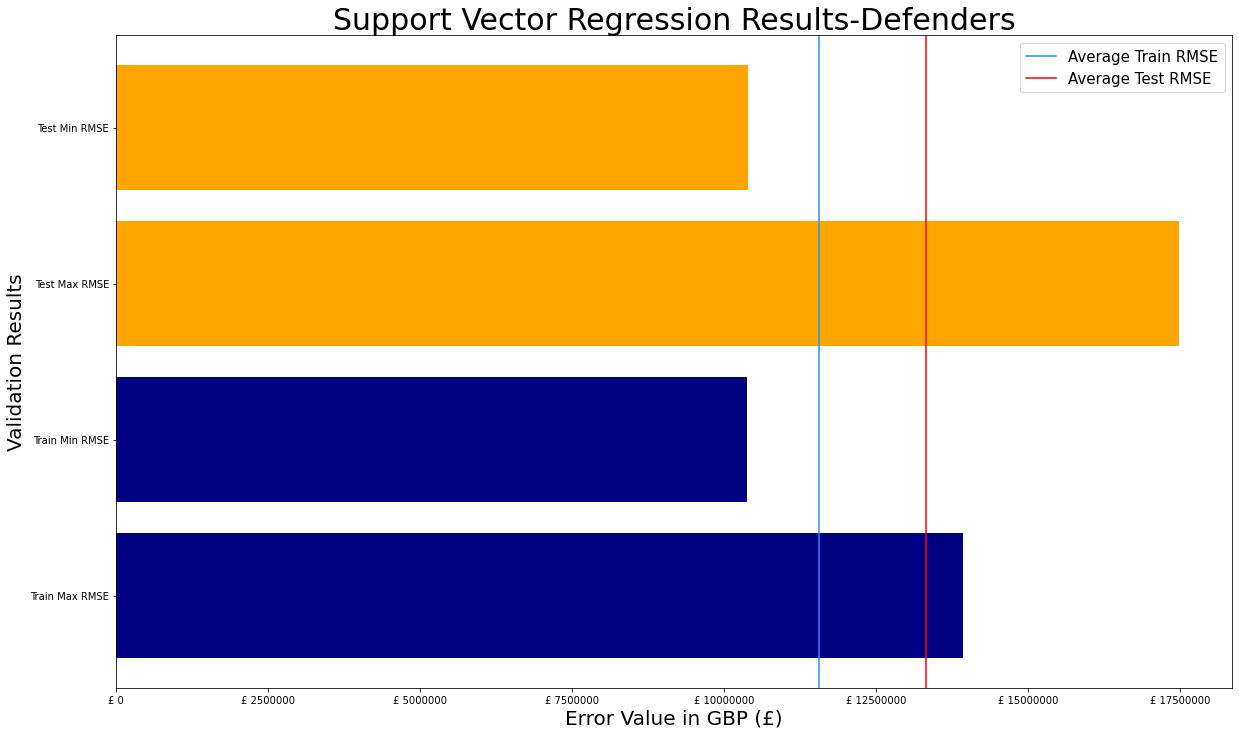

In [32]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,int(max(results_def['Max RMSE'])+1000000),2500000))
y_ticks = [1,2,3,4]
y_labels = ['Train Max RMSE','Train Min RMSE','Test Max RMSE','Test Min RMSE']

train_max_pos = 1
train_max = results_def.iloc[0][2]
ax.barh(train_max_pos,train_max,color='navy')

train_min_pos = 2
train_min = results_def.iloc[0][3]
ax.barh(train_min_pos,train_min,color='navy')

test_max_pos = 3
test_max = results_def.iloc[1][2]
ax.barh(test_max_pos,test_max,color='orange')

test_min_pos = 4
test_min = results_def.iloc[1][3]
ax.barh(test_min_pos,test_min,color='orange')

ax.axvline(x = results_def.iloc[0][1],label = 'Average Train RMSE',color='dodgerblue')
ax.axvline(x = results_def.iloc[1][1],label = 'Average Test RMSE',color='red')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Support Vector Regression Results-Defenders',fontsize=30)
ax.legend(fontsize=15);

# Comparing Model Performance for all three Positions

### Attackers

In [33]:
results_att

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Train,15409824.23,18134988.22,12979890.29
1,Test,23554339.01,53585496.11,12764873.01


### Midfielders

In [34]:
results_mid

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Train,14851310.40,19827968.51,12091408.77
1,Test,14107116.01,17710229.19,9903390.56


### Defenders

In [35]:
results_def

,Train/Test,Avg RMSE,Max RMSE,Min RMSE
0,Train,11569783.85,13936954.63,10379824.91
1,Test,13332388.56,17486398.15,10389894.37


## Visualizing RMSEs together

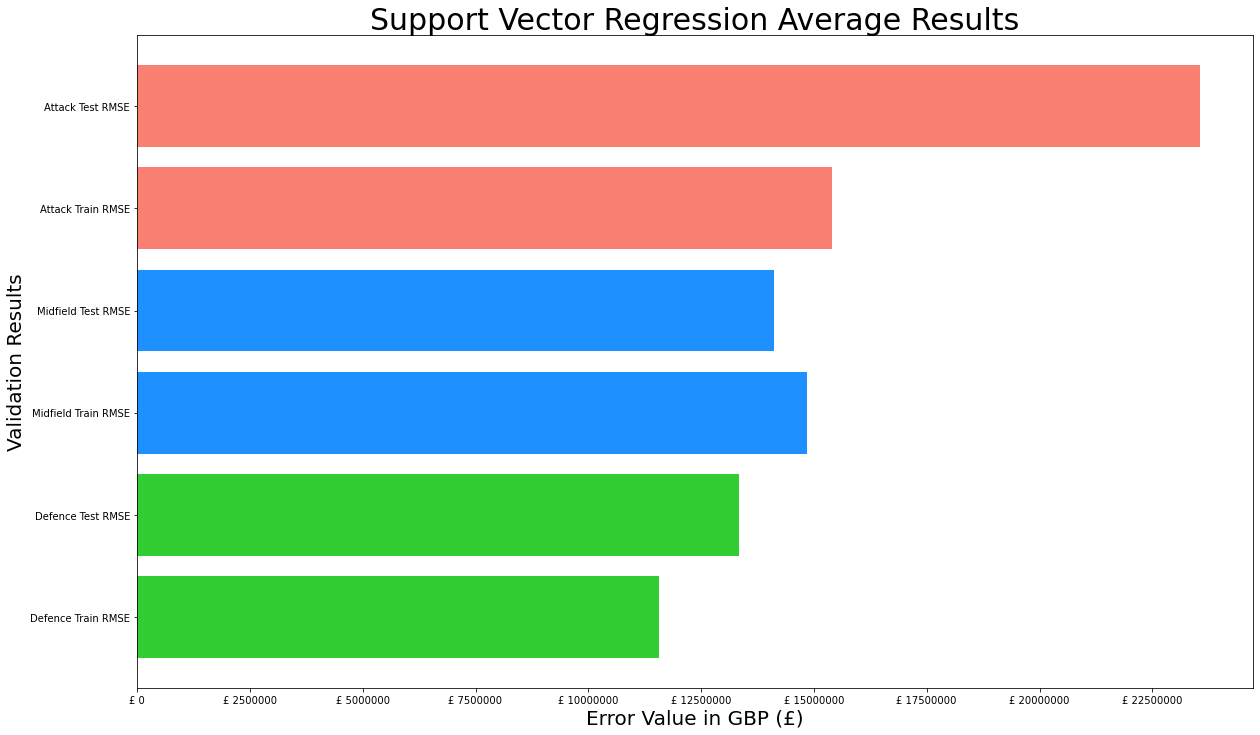

In [36]:
fig, ax = plt.subplots(figsize=(20,12))

x_ticks = list(range(0,int(max([max(results_att['Avg RMSE']),max(results_mid['Avg RMSE']),max(results_def['Avg RMSE'])])+1000000),2500000))
y_ticks = [1,2,3,4,5,6]
y_labels = ['Defence Train RMSE','Defence Test RMSE',
            'Midfield Train RMSE','Midfield Test RMSE',
            'Attack Train RMSE','Attack Test RMSE',]

#Defence Results
def_train_pos = 1
def_train = results_def.iloc[0][1]
ax.barh(def_train_pos,def_train,color='limegreen')

def_test_pos = 2
def_test = results_def.iloc[1][1]
ax.barh(def_test_pos,def_test,color='limegreen')

#Midfield Results
mid_train_pos = 3
mid_train = results_mid.iloc[0][1]
ax.barh(mid_train_pos,mid_train,color='dodgerblue')

mid_test_pos = 4
mid_test = results_mid.iloc[1][1]
ax.barh(mid_test_pos,mid_test,color='dodgerblue')

#Attack Results
att_train_pos = 5
att_train = results_att.iloc[0][1]
ax.barh(att_train_pos,att_train,color='salmon')

att_test_pos = 6
att_test = results_att.iloc[1][1]
ax.barh(att_test_pos,att_test,color='salmon')


#Labels
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'£ {a}' for a in x_ticks])
ax.set_xlabel('Error Value in GBP (£)',fontsize=20)
ax.set_ylabel('Validation Results',fontsize=20)
ax.set_title('Support Vector Regression Average Results',fontsize=30);